Link to Github repository: https://github.com/lucasmaretti/NetflixEDA

## 1) Importing packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
plt.style.use('ggplot')
%matplotlib inline

## 2) Overall view of data

In [2]:
df = pd.read_csv('./netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### 2.1) Checking data types and NaNs

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [4]:
df.isna().mean().sort_values(ascending = False)

director        0.306793
cast            0.092205
country         0.065109
date_added      0.001284
rating          0.000899
description     0.000000
listed_in       0.000000
duration        0.000000
release_year    0.000000
title           0.000000
type            0.000000
show_id         0.000000
dtype: float64

We can consider dropping the director and cast columns due to its high number of NAs

In [5]:
df.drop(columns = ['director'], inplace = True)
df.drop(columns = ['cast'], inplace = True)

### 2.2) Checking some variables individually and converting when helpful

- country variable:

In [6]:
len(df.country.dropna().unique().tolist())

681

681 is an strange number of countries. Let's see why this is happening

In [7]:
sorted(df.country.dropna().unique().tolist())

['Argentina',
 'Argentina, Brazil, France, Poland, Germany, Denmark',
 'Argentina, Chile',
 'Argentina, Chile, Peru',
 'Argentina, France',
 'Argentina, France, United States, Germany, Qatar',
 'Argentina, Italy',
 'Argentina, Spain',
 'Argentina, United States',
 'Argentina, United States, Mexico',
 'Argentina, Uruguay, Serbia',
 'Argentina, Uruguay, Spain, France',
 'Australia',
 'Australia, Armenia, Japan, Jordan, Mexico, Mongolia, New Zealand, Philippines, South Africa, Sweden, United States, Uruguay',
 'Australia, Canada',
 'Australia, France',
 'Australia, France, Ireland',
 'Australia, India',
 'Australia, Iraq',
 'Australia, New Zealand',
 'Australia, New Zealand, United States',
 'Australia, United Arab Emirates',
 'Australia, United Kingdom',
 'Australia, United Kingdom, Canada',
 'Australia, United Kingdom, United Arab Emirates, Canada',
 'Australia, United Kingdom, United States, New Zealand, Italy, France',
 'Australia, United States',
 'Austria',
 'Austria, Czech Republic

There are contributions between countries for some productions, leading to groups of countries, increasing the size of the list. This might need to be taken into account when analysing data by country

If we consider that the first country listed is the "main" country of production, we can create the following variable

In [8]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

In [9]:
# Lets retrieve just the first country
df['principal_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['principal_country'].head()

0           Brazil
1           Mexico
2        Singapore
3    United States
4    United States
Name: principal_country, dtype: object

- type

There 2 types of content: TV Show and Movies

In [10]:
df.type.unique()

array(['TV Show', 'Movie'], dtype=object)

- date_added: when the show was added to the Netflix catalog - needs to be converted to datetime format to extract month and year for further analysis


- release_year: year when TV Show / Movie was released

- listed_in: content classification
- cast

Both these variables contain sequence of strings delimited by comma for each observation. Depending on the analysis, parsing of this data might be required

In [11]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

- rating: definition taken from wikipedia: "systems for evaluating the content and reporting the suitability of television programs for children, teenagers, or adults. Many countries have their own television rating system and countries' rating processes vary by local priorities. Programs are rated by the organization that manages the system, the broadcaster, or the content producers."

https://en.wikipedia.org/wiki/Television_content_rating_system


In [12]:
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

Might be useful to group these to perform some type of analysis, eg., 3 groups: children, teens and adults. For instance we will the classification provided in the notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly

In [13]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)

- duration: this variable needs conversion as well. Changing it to numeric will allow analysis such as average duration of movies and # of seasons of TV shows

In [14]:
df.duration.unique()

array(['4 Seasons', '93 min', '78 min', '80 min', '123 min', '1 Season',
       '95 min', '119 min', '118 min', '143 min', '103 min', '89 min',
       '91 min', '149 min', '144 min', '124 min', '87 min', '110 min',
       '128 min', '117 min', '100 min', '2 Seasons', '84 min', '99 min',
       '90 min', '102 min', '104 min', '105 min', '56 min', '125 min',
       '81 min', '97 min', '106 min', '107 min', '109 min', '44 min',
       '75 min', '101 min', '3 Seasons', '37 min', '113 min', '114 min',
       '130 min', '94 min', '140 min', '135 min', '82 min', '70 min',
       '121 min', '92 min', '164 min', '53 min', '83 min', '116 min',
       '86 min', '120 min', '96 min', '126 min', '129 min', '77 min',
       '137 min', '148 min', '28 min', '122 min', '176 min', '85 min',
       '22 min', '68 min', '111 min', '29 min', '142 min', '168 min',
       '21 min', '59 min', '20 min', '98 min', '108 min', '76 min',
       '26 min', '156 min', '30 min', '57 min', '150 min', '133 min',
       '1

In [15]:
df['duration'] = df['duration'].astype(str)
df['duration_int'] = df['duration'].str.extract('(\d+)')

### 2.3) Converting some data types

#### Converting date_added to datetime

In [16]:
df['dt_added'] = pd.to_datetime(df['date_added'], infer_datetime_format = True)

df['year_added'] = pd.DatetimeIndex(df['dt_added']).year
df['year_added'] = df['year_added'].fillna(0)
df['year_added'] = df['year_added'].astype(int)


df['month_added'] = pd.DatetimeIndex(df['dt_added']).month
df['month_added'] = df['month_added'].fillna(0)
df['month_added'] = df['month_added'].astype(int)

# The next variables will be useful when plotting stuff by month

month_numbers = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ['January', 'February', 'March','April', 'May', 'June', 'July','August','September','October',
               'November','December']

## 3) Exploratory data analysis

In [17]:
#Taking a look at the dataframe after all the changes:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,principal_country,genre,target_ages,duration_int,dt_added,year_added,month_added
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,Brazil,"[International TV Shows, TV Dramas, TV Sci-Fi ...",Adults,4,2020-08-14,2020,8
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Mexico,"[Dramas, International Movies]",Adults,93,2016-12-23,2016,12
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Singapore,"[Horror Movies, International Movies]",Adults,78,2018-12-20,2018,12
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",United States,"[Action & Adventure, Independent Movies, Sci-F...",Teens,80,2017-11-16,2017,11
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,United States,[Dramas],Teens,123,2020-01-01,2020,1


In [18]:
a = df.groupby(['type']).count()[df.columns[df.columns == 'title']].reset_index()
a

,type,title
0,Movie,5377
1,TV Show,2410


In [19]:
total = a.title.sum()

In [20]:
a['percent'] = round((a['title'] / total) * 100,2)
a

,type,title,percent
0,Movie,5377,69.05
1,TV Show,2410,30.95


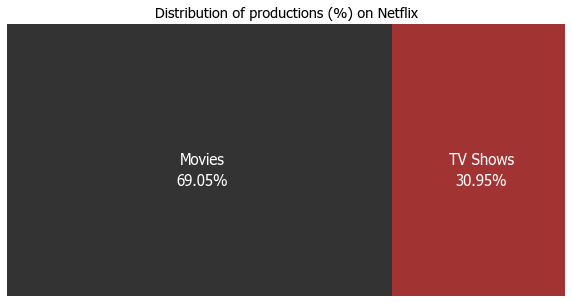

In [21]:
# Creating a tree map of type of content

fig, ax = plt.subplots(1,1,figsize=(10, 5),)

squarify.plot(sizes=a['percent'], color=["black","darkred"], alpha=.8)

ax.annotate(f"{'Movies'}", 
                   xy=(35, 50),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='tahoma',
                   color='white')

ax.annotate(f"{a['percent'][0]}%", 
                   xy=(35, 42),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='tahoma',
                   color='white')


ax.annotate(f"{'TV Shows'}", 
                   xy=(85, 50),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='tahoma',
                   color='white')

ax.annotate(f"{a['percent'][1]}%", 
                   xy=(85, 42),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='tahoma',
                   color='white')


plt.axis('off')
plt.xlabel('Percentage')
plt.title('Distribution of productions (%) on Netflix', fontfamily='tahoma')
plt.show()

Text(0.13, 0.9, 'Top 10 content producers')

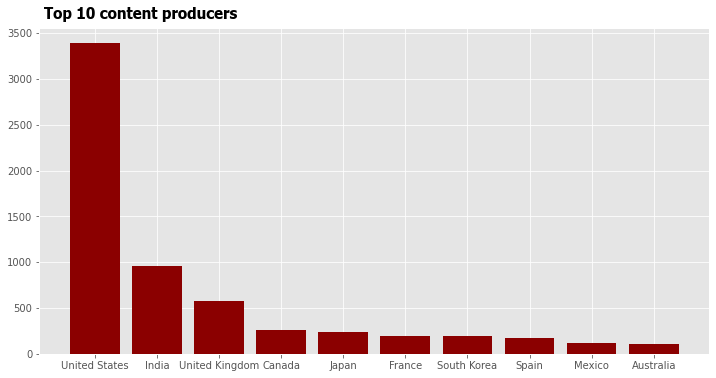

In [22]:
df['count'] = 1
data = df.groupby('principal_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, color = 'darkred')
fig.text(0.13, 0.9, 'Top 10 content producers', fontsize=15, fontweight='bold', fontfamily='tahoma')

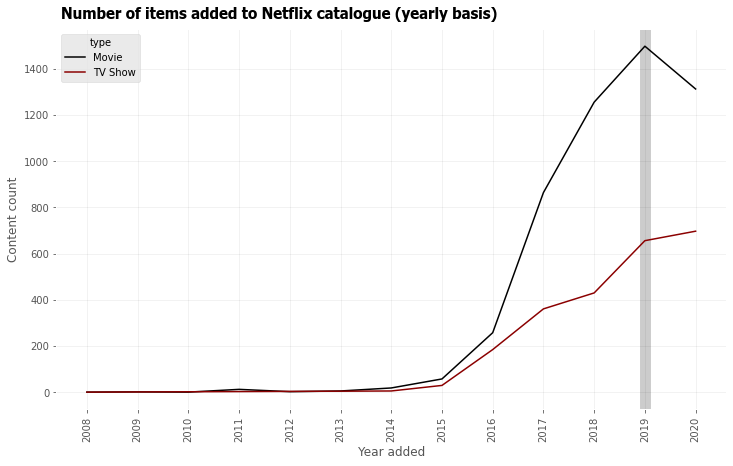

In [23]:
#Content added over time
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
df_2020 = df[df['year_added'].isin(years)]

b = df_2020.groupby(['year_added', 'type']).count()[df_2020.columns[df.columns == 'title']].reset_index()

fig, ax = plt.subplots(1,1,figsize=(12, 7),)
sns.lineplot(x='year_added', y = 'title', hue = 'type', palette = ['black', 'darkred'],data= b[b['year_added'] > 0])
plt.xlabel('Year added')
x = [2008,2021]
plt.xticks(np.arange(min(x), max(x)+1, 1.0), rotation = 'vertical')
plt.ylabel('Content count')
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.1)
ax.grid(True)
plt.axvspan(2018.9, 2019.1, color='black', alpha=0.2)
fig.text(0.13, 0.9, 'Number of items added to Netflix catalogue (yearly basis)', fontsize=15, fontweight='bold', fontfamily='tahoma')
plt.show()

In [24]:
country_order = df['principal_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'principal_country']].groupby('principal_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]



/Users/lucasmaretti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


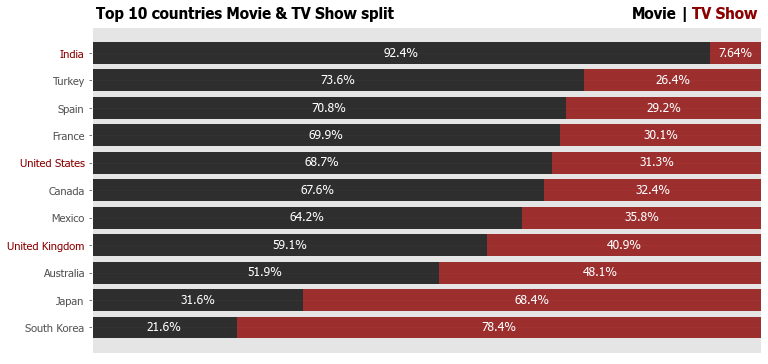

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12, 6),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='black', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='darkred', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='tahoma', fontsize=11)

# percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='tahoma',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='tahoma',
                   color='white')
    

fig.text(0.13, 0.9, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='tahoma')      

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='tahoma', fontsize=15, color='black')
fig.text(0.805,0.9,"|", fontweight="bold", fontfamily='tahoma', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='tahoma', fontsize=15, color='darkred')

plt.gca().get_yticklabels()[3].set_color('darkred')
plt.gca().get_yticklabels()[6].set_color('darkred')
plt.gca().get_yticklabels()[10].set_color('darkred')


This visualization above was inspired by Joshua Sword's notebook on Kaggle. Do check out his work, it is pretty amazing: https://www.kaggle.com/joshuaswords/netflix-data-visualization

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer 
def calculate_mlb(series):
    
    '''This function takes a pandas series (dataframe column) that has multiple entries (labels) and return
    its binarized form (each label becomes a column in a new data frame with 1 indicating its presence
    and 0 if not)'''
    
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

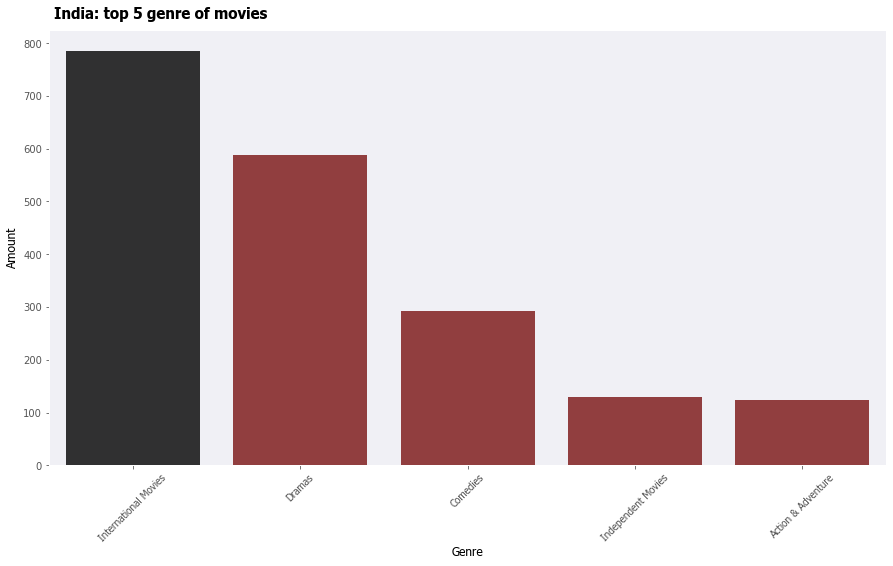

In [27]:
df_india = df[df['country'] == 'India']
df_india = df_india[df_india['type'] == 'Movie']

genres_df = calculate_mlb(df_india['genre'])
tdata = pd.DataFrame(genres_df.sum().sort_values(ascending=False).reset_index())
tdata.columns = ['Genre', 'Amount']

fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax = sns.barplot(x="Genre", y="Amount", palette = ['black', 'darkred','darkred','darkred','darkred' ], alpha = 0.8, data=tdata.nlargest(5, 'Amount'))
plt.xticks(rotation=45, fontfamily='tahoma')
plt.xlabel('Genre', fontfamily='tahoma', color = 'black')
plt.ylabel('Amount', fontfamily='tahoma', color = 'black')
fig.text(0.13, 0.9, 'India: top 5 genre of movies', fontsize=15, fontweight='bold', fontfamily='tahoma')
ax.set_facecolor('#f0f0f5')
ax.grid(False)
plt.show()

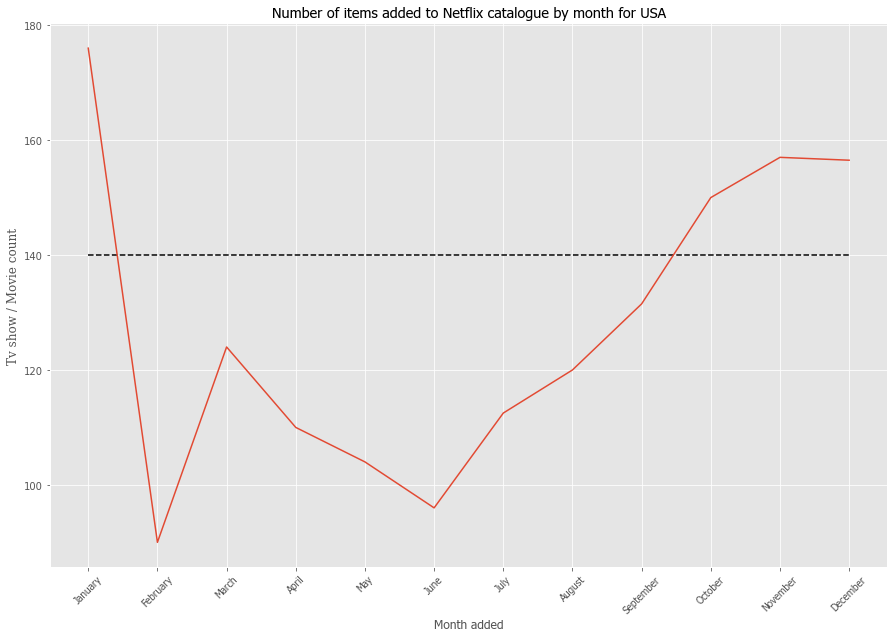

In [28]:
df_usa = df[df['country'] == 'United States']

w6 = df_usa.groupby(['month_added', 'type']).count()[df.columns[df.columns == 'title']].reset_index()

plt.figure(figsize=(15,10))
sns.lineplot(x='month_added', y = 'title', ci = None, data= w6[w6['month_added'] > 0])
plt.xlabel('Month added', fontfamily='tahoma')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['January', 'February', 'March','April', 'May', 'June', 'July','August',
'September','October','November','December'], rotation=45, fontfamily='tahoma')# Set text labels and properties.
plt.hlines(y=140, xmin = 1, xmax = 12, color = 'black',linestyles = 'dashed', label = 'Threshold')
plt.ylabel('Tv show / Movie count', fontfamily='serif')
plt.title('Number of items added to Netflix catalogue by month for USA', fontfamily='tahoma')
plt.show()


Majority of new contents realease between September and January

In [29]:
data = df.groupby('principal_country')[['principal_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:3]
data = data['principal_country']


df_heatmap = df.loc[df['principal_country'].isin(data)]

In [30]:
df_heatmap = pd.crosstab(df_heatmap['principal_country'],df_heatmap['target_ages'],normalize = "index").T

In [31]:
df_heatmap

principal_country,India,United Kingdom,United States
target_ages,,,
Adults,0.259414,0.526863,0.462788
Kids,0.015690,0.077990,0.089191
Older Kids,0.163180,0.183709,0.202304
Teens,0.561715,0.211438,0.245718


In [32]:
country_order2 = ['United States', 'India','United Kingdom']

age_order = ['Kids','Older Kids','Teens','Adults']
df_heatmap.loc[age_order,country_order2]

principal_country,United States,India,United Kingdom
target_ages,,,
Kids,0.089191,0.015690,0.077990
Older Kids,0.202304,0.163180,0.183709
Teens,0.245718,0.561715,0.211438
Adults,0.462788,0.259414,0.526863


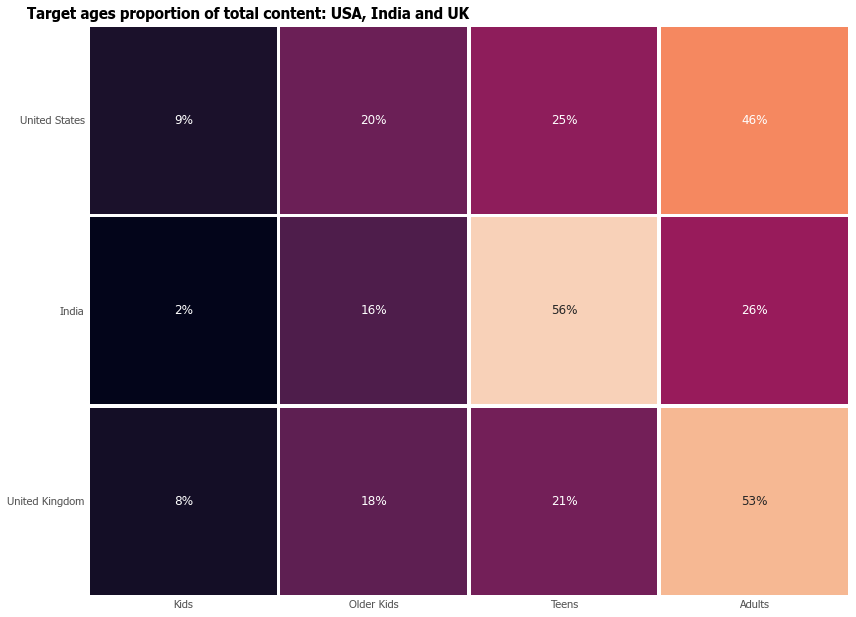

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

country_order2 = ['United States', 'India', 'United Kingdom']

age_order = ['Kids','Older Kids','Teens','Adults']


sns.heatmap(df_heatmap.T.loc[country_order2,age_order],square=True,linewidth=2.5,cbar=False,
            annot=True,fmt='1.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)


ax.set_yticklabels(ax.get_yticklabels(), fontfamily='tahoma', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='tahoma', rotation=0, fontsize=11)

plt.title('Target ages proportion of total content: USA, India and UK', fontweight='bold', fontfamily='tahoma', fontsize=15,ha='right') 

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()